## Importing packages

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import *
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import os
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb
from PIL import Image
from keras.preprocessing.image import  img_to_array, load_img
from sklearn.model_selection import train_test_split

2022-03-19 14:16:14.396698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
NUM_OF_IMAGES=10

## Preparing the dataset
    1.We load our images from the given directory
    2.We convert our images to numpy arrays


In [3]:
# dataset directory
direc='/home/ned/Desktop/Python_Projects/Datasets/tiny-imagenet-200/train/n01443537/images' 

# counter to limit the amount of images we read
counter=0

images_to_arrays=[]
img_input=[]

for x in os.listdir(direc):
    # we only read the first 'counter' amount of Jpegs
    if x.endswith('.JPEG') and counter<10:      
        counter+=1
        # Generating the corrosponsing path to the picture
        path=direc+'/'+x
        target_size=(64,64)
        # loading images from the path
        img_input.append(load_img(path,target_size=target_size))
        
# Converting all the pictures to numpy arrays       
for x in img_input:
    #print(img_to_array(x).shape)
    images_to_arrays.append(img_to_array(x))          
images_to_arrays=np.array(images_to_arrays)
# print(images_to_arrays.shape)

### Side Functions:
    1.We define plotChannels function to assist in plotting the bounds/ranges of each of the channel types
    2.We define L_extract to extract the different channels from an image's LAB version

In [4]:
def plotChannels(images_to_arrays,labels=['r','g','b']):
    #going over each label and calculating max/min values
    for x,y in enumerate(labels):
        mi=np.min(images_to_arrays[:,:,:,x])
        ma=np.max(images_to_arrays[:,:,:,x])
        print('{}: min={:8.4f}, max={:8.4f}'.format(y,mi,ma))

plotChannels(images_to_arrays,labels=['r','g','b'])

r: min=  0.0000, max=255.0000
g: min=  0.0000, max=255.0000
b: min=  0.0000, max=255.0000


In [5]:
def L_extract(img,dim):
    result=np.zeros(img.shape)
    # we return the given channel of LAB in rgb and adjust the brightness only on A and B
    if dim != 0:
        result[:,:,0]=60
    result[:,:,dim]=img[:,:,dim]
    #convert back to rgb to plot
#     result=lab2rgb(result)
    return result


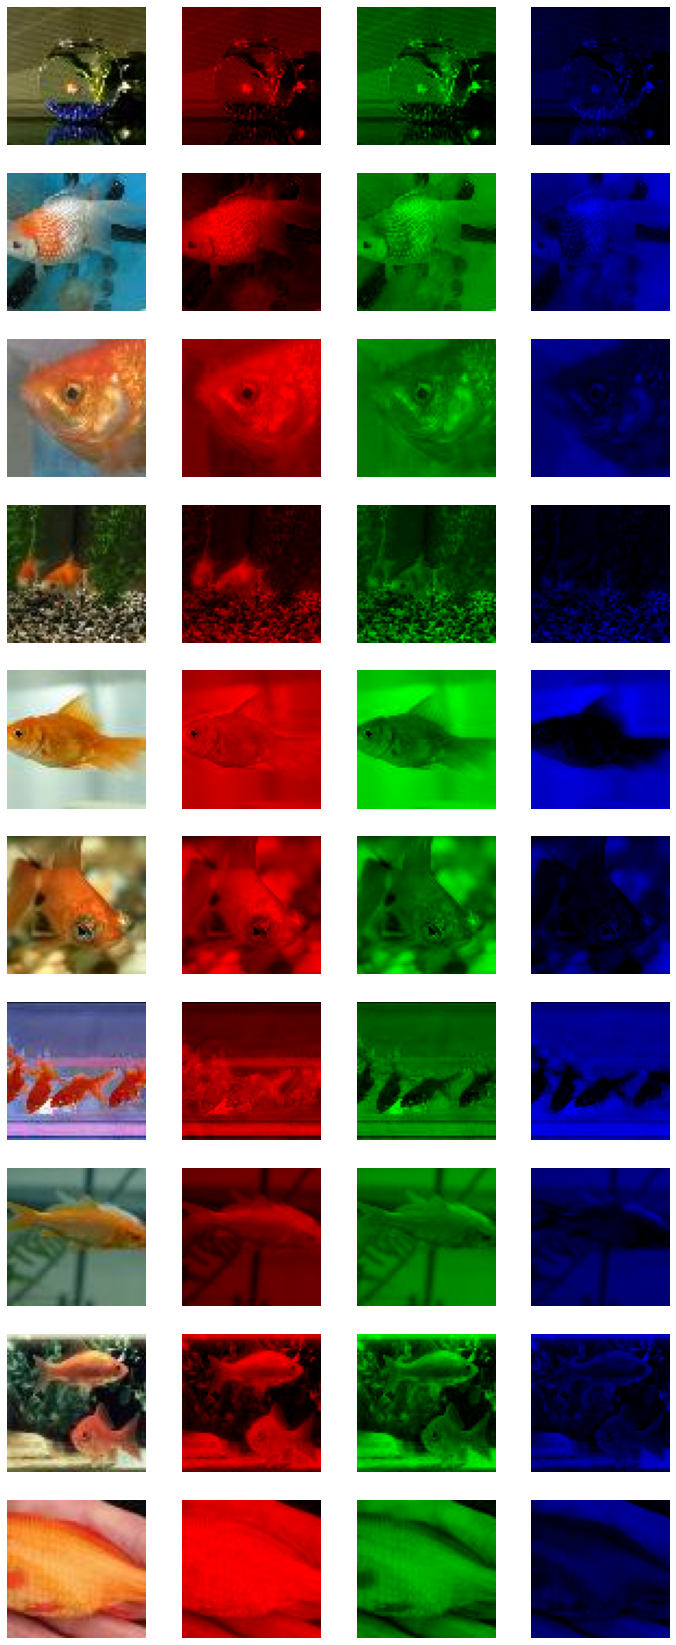

In [6]:
count=1
plut=plt.figure(figsize=(12,3*images_to_arrays.shape[0]))
for channel in images_to_arrays:
    #adding the subplot for the original picture
    x=plut.add_subplot(images_to_arrays.shape[0],4,count)
    x.imshow(channel/255.0); x.axis('off')
    count+=1
    
    for dim,label in enumerate(['r','g','b']):
        #adding the subplot for each channel for the original picture
        uni_colored=np.zeros(channel.shape)
        #we set each channel excluding the one we want to 0
        uni_colored[:,:,dim]=channel[:,:,dim]
        x=plut.add_subplot(images_to_arrays.shape[0],4,count)
        x.imshow(uni_colored/255.0); x.axis('off')
        count+=1
    

## Converting RGB to LAB

In [7]:
normalized_images=images_to_arrays/255.0
plotChannels(normalized_images,['r','g','b'])
img_arr_lab=rgb2lab(normalized_images)
plotChannels(img_arr_lab,['l','a','b'])

r: min=  0.0000, max=  1.0000
g: min=  0.0000, max=  1.0000
b: min=  0.0000, max=  1.0000
l: min=  0.0000, max= 99.9268
a: min=-27.8758, max= 68.9597
b: min=-52.7081, max= 73.3010


In [8]:
img_lab_rgb=np.zeros(img_arr_lab.shape)
img_lab_rgb=lab2rgb(img_arr_lab)
plotChannels(img_lab_rgb.reshape((1,)+img_lab_rgb.shape),['r','g','b'])

r: min=  0.0000, max=  1.0000
g: min=  0.0000, max=  0.9843
b: min=  0.0000, max=  1.0000


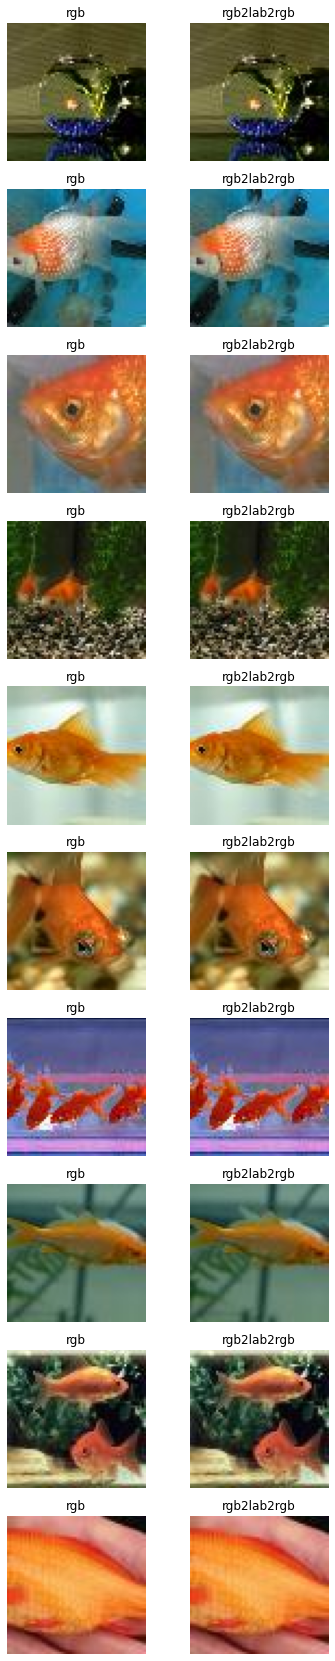

In [9]:
count=1
fig=plt.figure(figsize=(6,3*images_to_arrays.shape[0]))
#we enumerate over our original images and images after double conversion to compare the loss
for irgb,irgb2 in zip(normalized_images,img_lab_rgb):
    #original
    x=fig.add_subplot(images_to_arrays.shape[0],2,count)
    x.imshow(irgb); x.axis('off')
    x.set_title('rgb')
    count+=1
    #doubly converted
    x=fig.add_subplot(images_to_arrays.shape[0],2,count)
    x.imshow(irgb2); x.axis('off')
    x.set_title('rgb2lab2rgb')
    count+=1
    
plt.show()
    

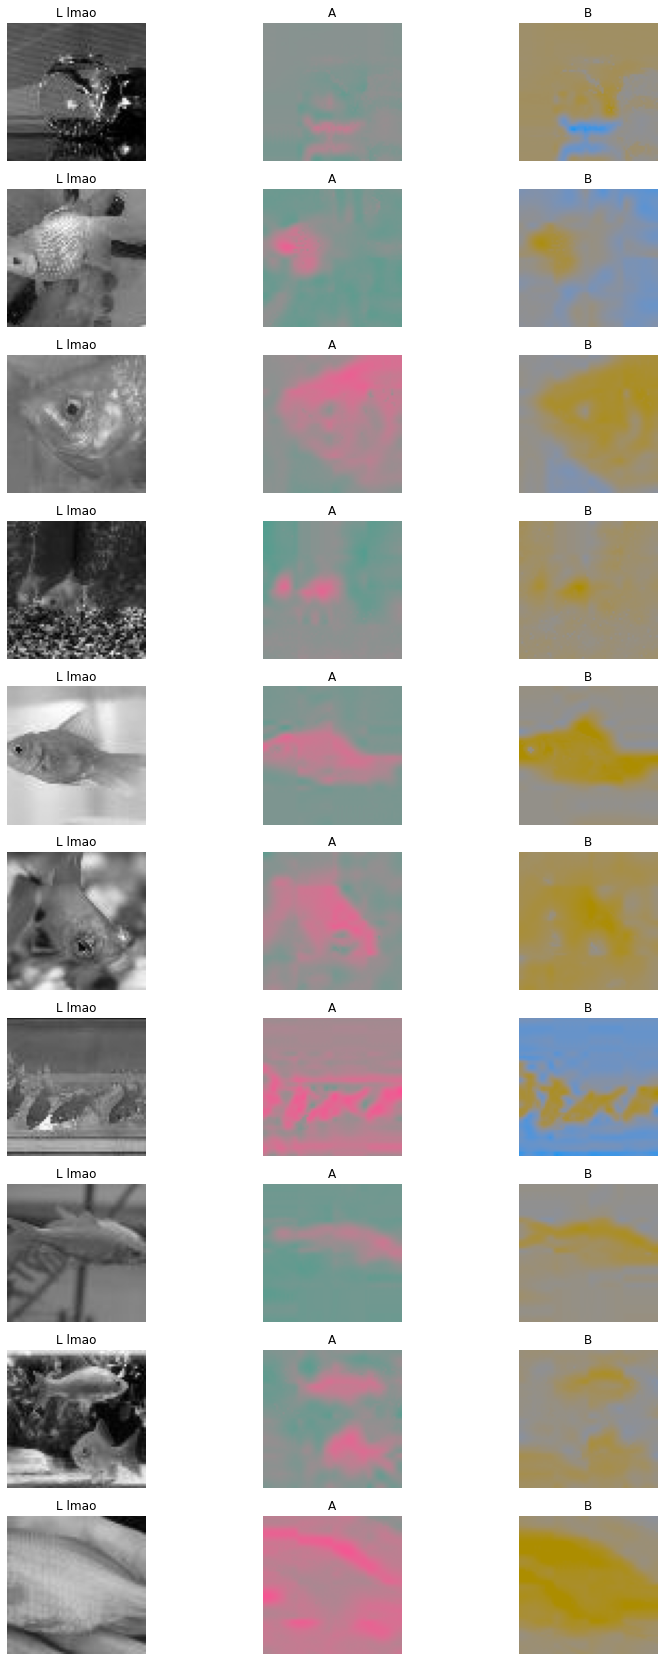

In [10]:
count=1
fig=plt.figure(figsize=(13,3*images_to_arrays.shape[0]))
#we plot the three channels of the LAB versions of our images
for img in img_arr_lab:
    #L
    x=fig.add_subplot(images_to_arrays.shape[0],3,count)
    lab_rgb_dim=L_extract(img,0)
    x.imshow(lab2rgb(lab_rgb_dim)) ; x.axis('off')
    x.set_title('L lmao')
    count+=1
    #A
    x=fig.add_subplot(images_to_arrays.shape[0],3,count)
    lab_rgb_dim=L_extract(img,1)
    x.imshow(lab2rgb(lab_rgb_dim)) ; x.axis('off')
    x.set_title('A')
    count+=1
    #B
    x=fig.add_subplot(images_to_arrays.shape[0],3,count)
    lab_rgb_dim=L_extract(img,2)
    x.imshow(lab2rgb(lab_rgb_dim)) ; x.axis('off')
    x.set_title('B')
    count+=1

plt.show()

In [11]:
L_array=[]
A_array=[]
B_array=[]
#we extract each dimension of the LAB images onto a different array
for img in img_arr_lab:
    L_array.append(L_extract(img,0))
    A_array.append(L_extract(img,1))
    B_array.append(L_extract(img,2))

#we insert our data into x and y such that x is our gray images (features), y is our A and B images (classes)


In [12]:
L_array = np.array(L_array)
CNNInput = []

for img in L_array:
    img1d = np.delete(img,1,2)
    img1d = np.delete(img1d,1,2)
    CNNInput.append(img1d)
CNNInput=np.array(CNNInput) 
CNNInput.shape

(10, 64, 64, 1)

In [13]:
A_array = np.array(A_array)
CNNOutputA = []

for img in A_array:
    img1d = np.delete(img,0,2)
    img1d = np.delete(img1d,1,2)
    CNNOutputA.append(img1d)
CNNOutputA=np.array(CNNOutputA) 
CNNOutputA.shape

(10, 64, 64, 1)

In [14]:
B_array = np.array(B_array)
CNNOutputB = []

for img in B_array:
    img1d = np.delete(img,1,2)
    img1d = np.delete(img1d,0,2)
    CNNOutputB.append(img1d)
CNNOutputB=np.array(CNNOutputB) 
CNNOutputB.shape



(10, 64, 64, 1)

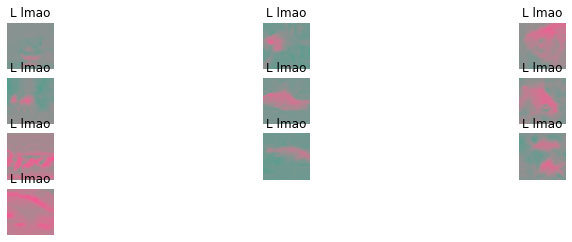

In [15]:
count=1
fig=plt.figure(figsize=(13,L_array.shape[0]))
for img in A_array: # Interchangable for channel that we want to plot
    x=fig.add_subplot(L_array.shape[0],3,count)
    x.imshow(lab2rgb(img)) ; x.axis('off')
    x.set_title('L lmao')
    count+=1

In [16]:
CNNOutput= np.hstack((CNNOutputA,CNNOutputB)).reshape(NUM_OF_IMAGES,2,64,64,1)
print(CNNOutput.shape)
#we split into train and test such that train=80% * overalldata
X_train, X_test, y_train, y_test = train_test_split(CNNInput, CNNOutputA, test_size=0.2)

(10, 2, 64, 64, 1)


In [17]:
batch_size=10
epochs=1
input_shape=(64,64,1)

In [18]:
inputLayer = tf.keras.Input(shape = input_shape)
# x = tf.random.normal(input_shape)
with tf.device('/gpu:0'):
    Con1 = tf.keras.layers.Conv2D(32,kernel_size=(6,6),activation="relu",padding="same",strides=(1,1))(inputLayer)
    Con2 = tf.keras.layers.Conv2D(64,kernel_size=(5,5),activation="relu",padding="same",strides=(2,2))(Con1)
    flattened = tf.keras.layers.Flatten()(Con2)
    Den1 = tf.keras.layers.Dense(4096,activation="linear")(flattened)
    model = tf.keras.Model(inputLayer,Den1)


2022-03-19 14:16:18.739077: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-19 14:16:18.739674: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-19 14:16:18.764528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 14:16:18.764667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.845GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-19 14:16:18.764685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-19 14:16:18.766041: I tensorflow/stream_executor/platform

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
model.compile(loss="MeanSquaredError",optimizer="adam",metrics=["accuracy"])
x= model.fit(X_train,y_train,batch_size=batch_size,epochs=1)